# EEG PROCESSING

In [501]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.signal
import mne
import ast

## OBJECTS

In [502]:
signal_1 = pd.read_csv("dato01.csv")[['timestamp', 'sample_number', 'channel_data']]
signal_2 = pd.read_csv("datos.csv")[['timestamp', 'sample_number', 'channel_data']]
signal_1.channel_data = signal_1.channel_data.apply(ast.literal_eval)
signal_2.channel_data = signal_2.channel_data.apply(ast.literal_eval)

In [503]:
channel_data_df = signal_1.channel_data.apply(pd.Series) * 2.4 / 12 / (2**23 - 1) # Convert to a millivolts
channel_data_df.columns = ['channel_1', 'channel_2', 'channel_3', 'channel_4', 'channel_5', 'channel_6', 'channel_7', 'channel_8']
columnas_a_eliminar = ['channel_5', 'channel_6', 'channel_7', 'channel_8']
channel_data_df = channel_data_df.drop(columns=columnas_a_eliminar)
channel_data_df.shape

(5000, 4)

In [504]:
signal_1 = pd.concat([signal_1.drop('channel_data', axis=1), channel_data_df], axis=1)
signal_1.timestamp = signal_1.timestamp.apply(lambda x: (x - signal_1.timestamp.iloc[0]) / 10 ** 6)
signal_1.shape

(5000, 6)

In [505]:
channel_data_df = signal_2.channel_data.apply(pd.Series) * 2.4 / 12 / (2**23 - 1) # Convert to a millivolts
channel_data_df.columns = ['channel_1', 'channel_2', 'channel_3', 'channel_4', 'channel_5', 'channel_6', 'channel_7', 'channel_8']
columnas_a_eliminar = ['channel_5', 'channel_6', 'channel_7', 'channel_8']
channel_data_df = channel_data_df.drop(columns=columnas_a_eliminar)
channel_data_df.shape

(5000, 4)

In [506]:
signal_2 = pd.concat([signal_2.drop('channel_data', axis=1), channel_data_df], axis=1)
signal_2.timestamp = signal_2.timestamp.apply(lambda x: (x - signal_2.timestamp.iloc[0]) / 10 ** 6)
signal_2.shape

(5000, 6)

In [507]:
fs = 500. #Fp2 f8 t4 
info_1 = mne.create_info(['Fp2','F8','T6','O2'], 
                       sfreq=fs, ch_types='eeg')
info_1.set_montage('standard_1020')
info_1['description'] = 'Pruebas de EEG'
info_1['device_info'] = {'type':'Frontend', 'model':'AD1298'}
info_1['experimenter'] = 'Eloy'
info_1['line_freq'] = 50.0
info_1['subject_info'] = {'id':1,'last_name':'Yapur','first_name':'Jhoseline',
                        'birthday':(2002, 5, 12),'sex':2,'hand':1}
data_1 = signal_1.loc[:, 'channel_1':'channel_4'].values.T
eeg_raw_1 = mne.io.RawArray(data_1, info_1, verbose=True)

Creating RawArray with float64 data, n_channels=4, n_times=5000
    Range : 0 ... 4999 =      0.000 ...     9.998 secs
Ready.


In [508]:
info_2 = mne.create_info(['Fp2','F8','T6','O2'], 
                         sfreq=fs, ch_types='eeg')
info_2.set_montage('standard_1020')
info_2['description'] = 'Pruebas de EEG'
info_2['device_info'] = {'type':'Frontend', 'model':'AD1298'}
info_2['experimenter'] = 'Eloy'
info_2['line_freq'] = 50.0
info_2['subject_info'] = {'id':1,'last_name':'Yapur','first_name':'Jhoseline',
                        'birthday':(2002, 5, 12),'sex':2,'hand':1}
data_2 = signal_2.loc[:, 'channel_1':'channel_4'].values.T
eeg_raw_2 = mne.io.RawArray(data_2, info_2, verbose=True)

Creating RawArray with float64 data, n_channels=4, n_times=5000
    Range : 0 ... 4999 =      0.000 ...     9.998 secs
Ready.


## FILTERING

In [509]:
x1, t = eeg_raw_1.get_data(return_times=True, units='uV')
x2, t = eeg_raw_2.get_data(return_times=True, units='uV')
x1.shape

(4, 5000)

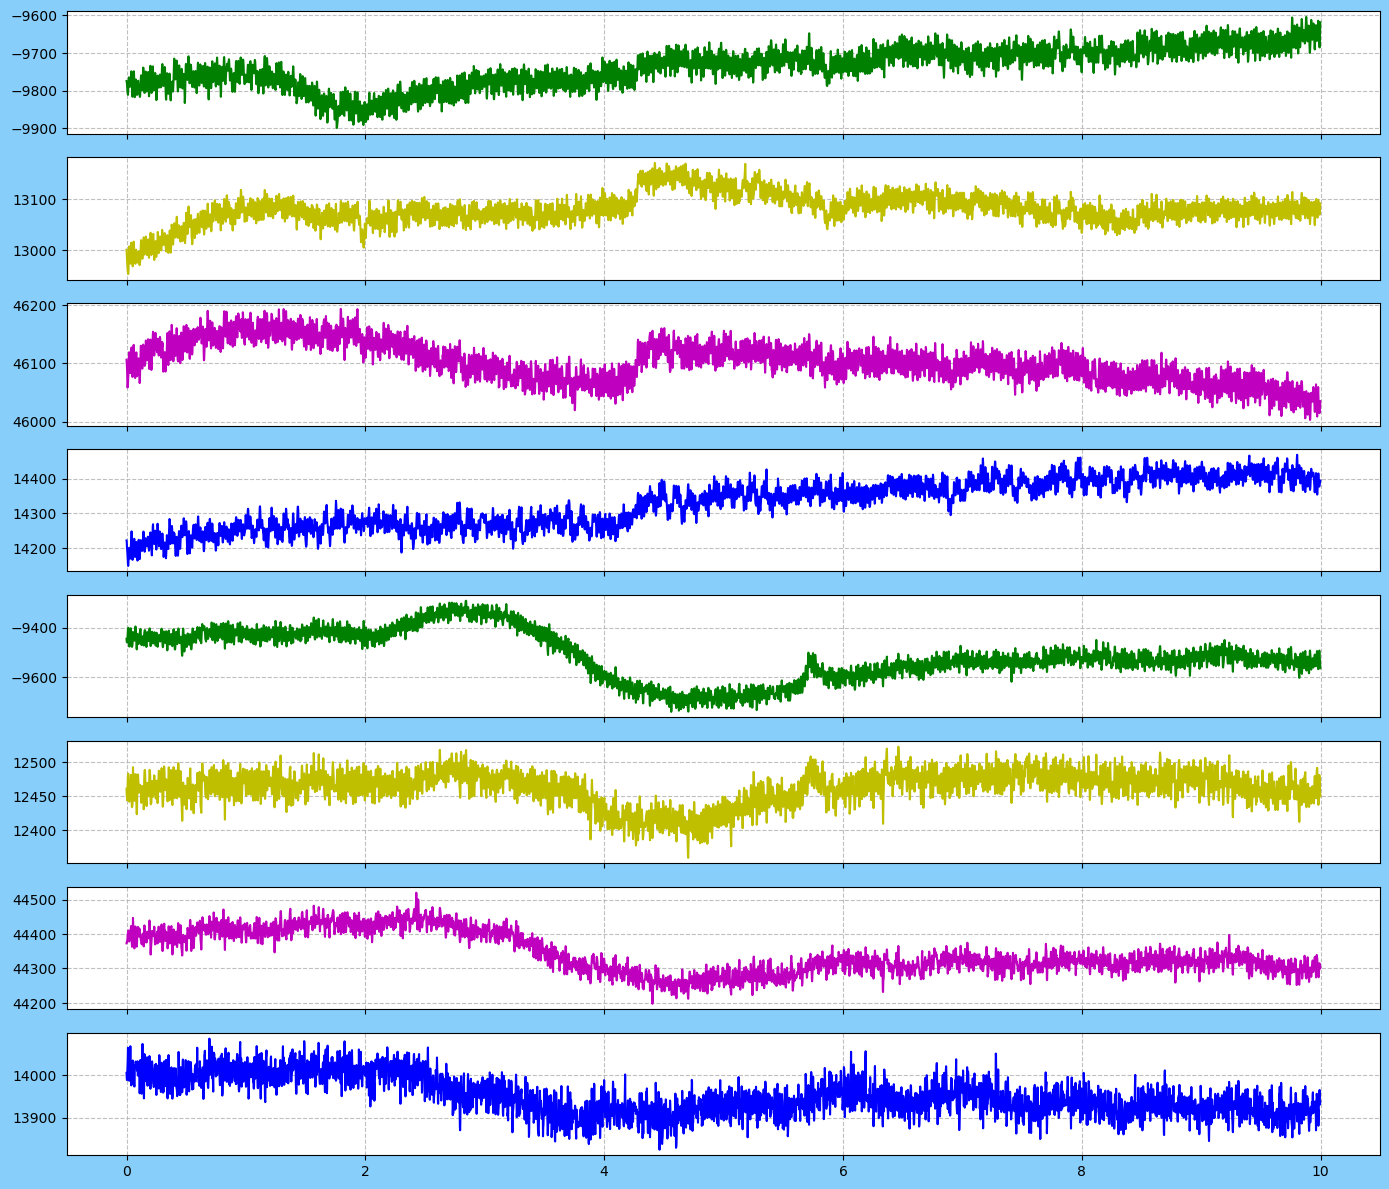

In [510]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8) = plt.subplots(nrows=8, ncols=1, num=0, figsize=(14, 12), tight_layout=True, sharex=True)
fig.set_facecolor('lightskyblue')

ax1.plot(t, x1[0], lw=1.5, color='g')
ax1.grid(alpha=.8, ls='--')
# ax1.set_xlim(t.min(), t.max() + 1/fs)

ax2.plot(t, x1[1], lw=1.5, color='y')
ax2.grid(alpha=.8, ls='--')

ax3.plot(t, x1[2], lw=1.5, color='m')
ax3.grid(alpha=.8, ls='--')
# ax3.set_ylim(-40, 40)

ax4.plot(t, x1[3], lw=1.5, color='b')
ax4.grid(alpha=.8, ls='--')
# ax4.set_ylim(-30, 30)

ax5.plot(t, x2[0], lw=1.5, color='g')
ax5.grid(alpha=.8, ls='--')
# ax5.set_ylim(-30, 30)

ax6.plot(t, x2[1], lw=1.5, color='y')
ax6.grid(alpha=.8, ls='--')
# ax6.set_ylim(-40, 40)

ax7.plot(t, x2[2], lw=1.5, color='m')
ax7.grid(alpha=.8, ls='--')

ax8.plot(t, x2[3], lw=1.5, color='b')
ax8.grid(alpha=.8, ls='--')

plt.show()

In [511]:
fl, fh = 0.5, 35.
eeg_raw_f_1 = eeg_raw_1.copy().filter(l_freq=fl, h_freq=fh, method='fir', phase='zero-double', fir_window='hamming', 
                                      fir_design='firwin', pad='reflect', verbose=True)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 35 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-12 dB cutoff frequency: 39.38 Hz)
- Filter length: 3301 samples (6.602 s)



In [512]:
eeg_raw_f_2 = eeg_raw_2.copy().filter(l_freq=fl, h_freq=fh, method='fir', phase='zero-double', fir_window='hamming', 
                                      fir_design='firwin', pad='reflect', verbose=True)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 35 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-12 dB cutoff frequency: 39.38 Hz)
- Filter length: 3301 samples (6.602 s)



In [513]:
# Obtener los datos del objeto Raw
x1, t = eeg_raw_f_1.get_data(return_times=True, units='uV')
x2, t = eeg_raw_f_2.get_data(return_times=True, units='uV')
x1.shape

(4, 5000)

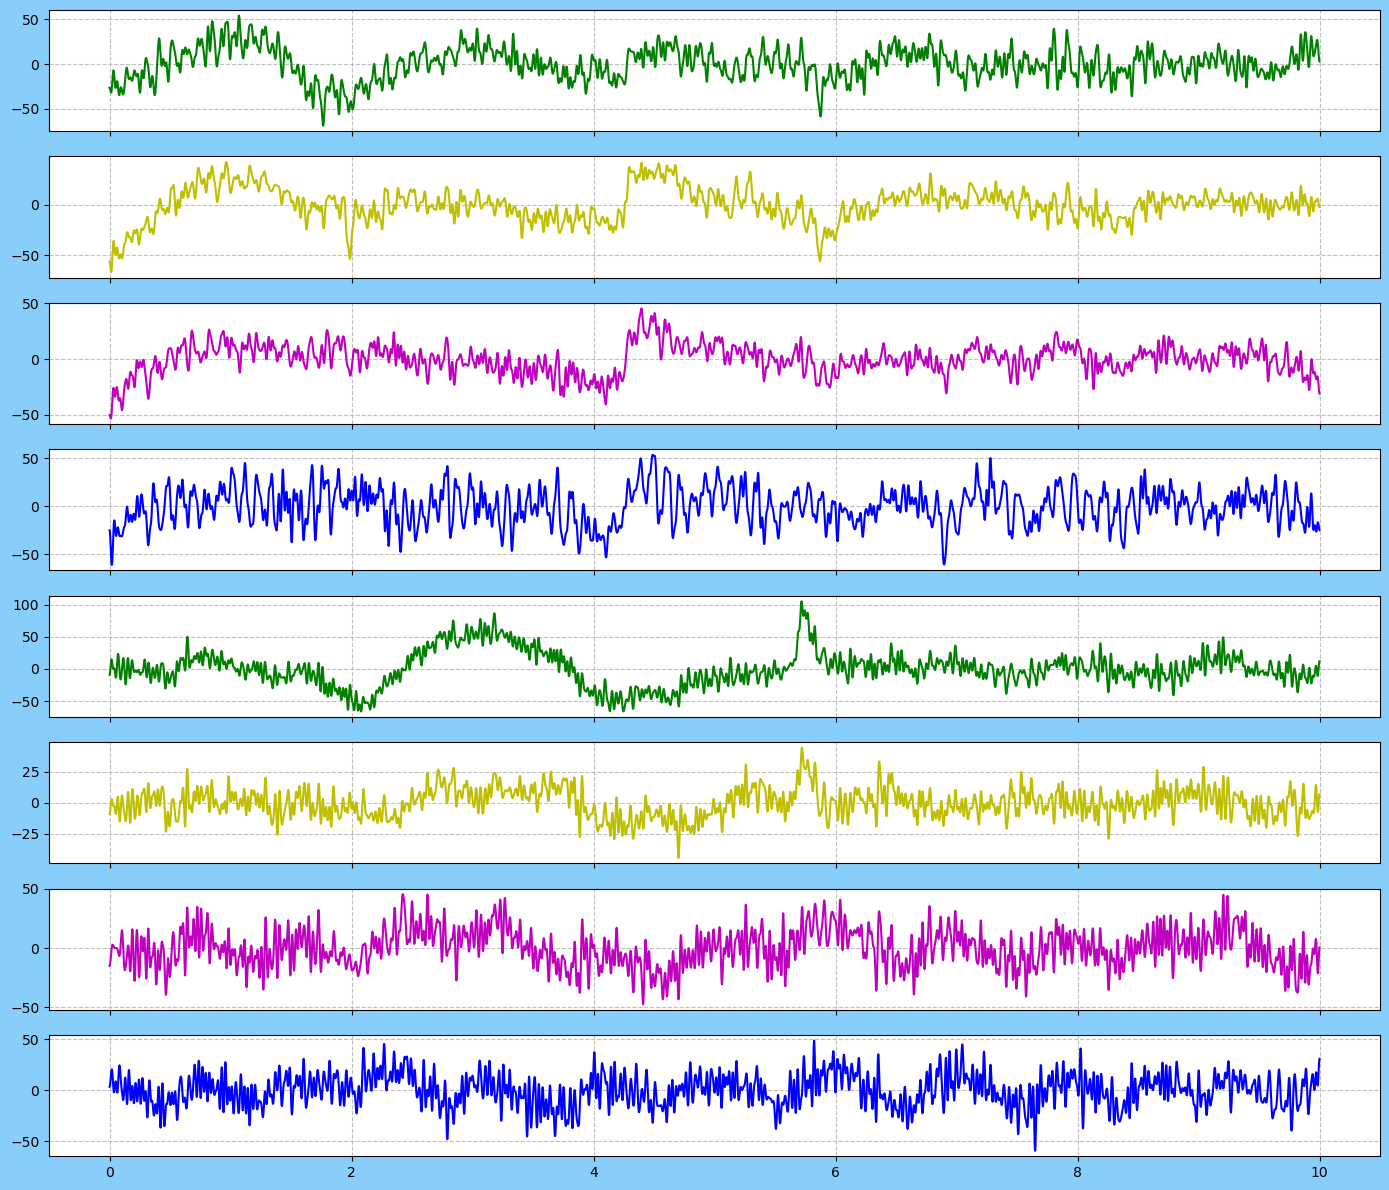

In [514]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8) = plt.subplots(nrows=8, ncols=1, num=0, figsize=(14, 12), tight_layout=True, sharex=True)
fig.set_facecolor('lightskyblue')

ax1.plot(t, x1[0], lw=1.5, color='g')
ax1.grid(alpha=.8, ls='--')
# ax1.set_xlim(t.min(), t.max() + 1/fs)
# ax1.set_ylim(-55, 55)

ax2.plot(t, x1[1], lw=1.5, color='y')
ax2.grid(alpha=.8, ls='--')
# ax2.set_ylim(-55, 55)

ax3.plot(t, x1[2], lw=1.5, color='m')
ax3.grid(alpha=.8, ls='--')
# ax3.set_ylim(-80, 80)

ax4.plot(t, x1[3], lw=1.5, color='b')
ax4.grid(alpha=.8, ls='--')
# ax4.set_ylim(-55, 55)

ax5.plot(t, x2[0], lw=1.5, color='g')
ax5.grid(alpha=.8, ls='--')
# ax5.set_ylim(-55, 55)

ax6.plot(t, x2[1], lw=1.5, color='y')
ax6.grid(alpha=.8, ls='--')
# ax6.set_ylim(-55, 55)

ax7.plot(t, x2[2], lw=1.5, color='m')
ax7.grid(alpha=.8, ls='--')

ax8.plot(t, x2[3], lw=1.5, color='b')
ax8.grid(alpha=.8, ls='--')
# ax8.set_ylim(-40, 40)

plt.show()

## SPECTRAL ANALYSIS

In [515]:
ventana = 4
win = int(ventana * fs)
eeg_PSD_f_1 = eeg_raw_f_1.compute_psd(method='welch', fmax=40.0, picks='data', n_fft=win, n_overlap=win // 2, n_per_seg=win, window='hann')
eeg_PSD_f_2 = eeg_raw_f_2.compute_psd(method='welch', fmax=40.0, picks='data', n_fft=win, n_overlap=win // 2, n_per_seg=win, window='hann')

Effective window size : 4.000 (s)
Effective window size : 4.000 (s)


Plotting power spectral density (dB=True).
Plotting power spectral density (dB=True).


C:\Users\ELOY\miniconda3\envs\eeg\lib\site-packages\mne\viz\utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


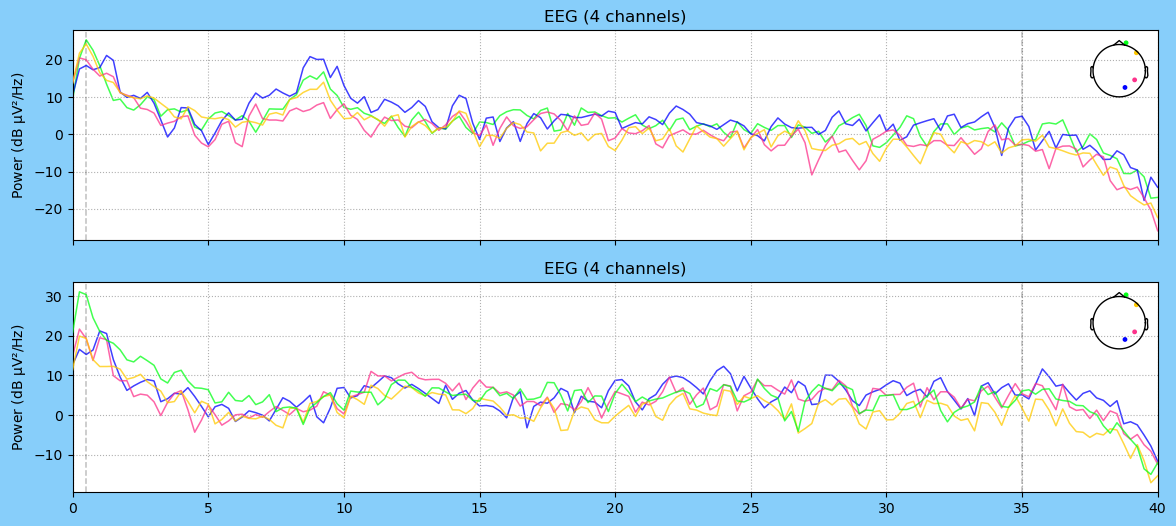

In [516]:
# Crear un objeto Figure y Axes personalizados

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, num=0, figsize=(14, 6), sharex=True)
fig.set_facecolor('lightskyblue')

# Graficar la PSD en el Axes personalizado
eeg_PSD_f_1.plot(dB=True, amplitude=False, color='r', spatial_colors=True, axes=ax1)
eeg_PSD_f_2.plot(dB=True, amplitude=False, color='b', spatial_colors=True, axes=ax2)

# Personalizar el Axes
for line in ax1.get_lines():
    line.set_linewidth(1.1)  # Aumentar el grosor de las líneas
for line in ax2.get_lines():
    line.set_linewidth(1.1)  # Aumentar el grosor de las líneas
# ax1.set_ylim([-10, 30])  # Cambiar los límites del eje y
# ax2.set_ylim([-10, 30])  # Cambiar los límites del eje y

plt.show()

## TIME-FRECUENCY ANALYSIS

No baseline correction applied


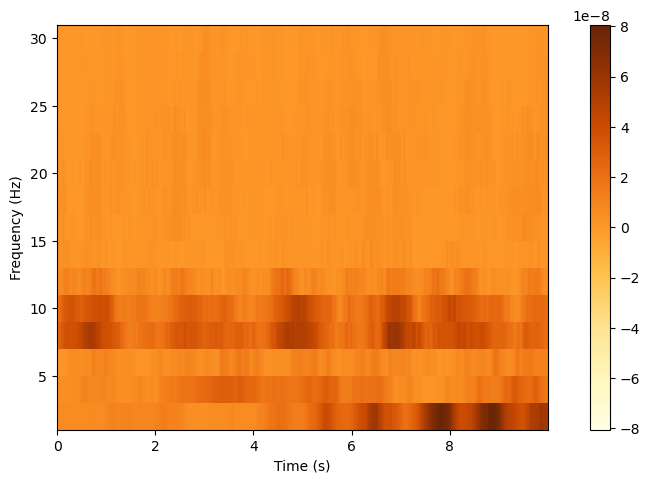

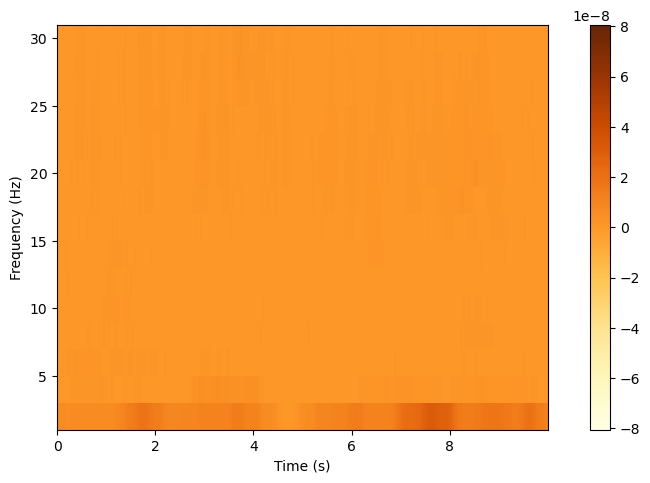

[<Figure size 640x480 with 2 Axes>, <Figure size 640x480 with 2 Axes>]

In [34]:
# Definir parámetros para la TFR
freqs = np.arange(2, 31, 2)  # Frecuencias de interés
n_cycles = freqs / 2.  # Número de ciclos por frecuencia

eeg_TFR_f_2 = eeg_raw_f_2.compute_tfr(method='multitaper', freqs=freqs, picks='data')#, n_cycles=n_cycles, time_bandwidth=4)#,
                                         #time_bandwidth=2, return_itc=False)
cmap = plt.cm.YlOrBr 
# Visualizar TFR
eeg_TFR_f_2.plot(cmap=cmap)

In [21]:
freqs = np.arange(2, 31, 2)  # Frecuencias de interés
n_cycles = freqs / 2.  # Número de ciclos por frecuencia

In [22]:
freqs

array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30])

In [23]:
n_cycles

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15.])